In [1]:
import networkx as nx
import ast
import ijson
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import random


## Functionality 3 - Shortest ordered walk

* To implement this functionality it was created a function called "shortest_ordered_walk", that returns the shortest possible walk from an author to another passing through a defined list of authors.
* For the implementation of the function was created an internal function "find_shortest_path" that uses the the networkx library.

In [361]:
def shortest_ordered_walk(collaboration_graph, authors_a, initial_author, end_author,N):
    centrality = nx.degree_centrality(collaboration_graph)
    top_N_authors = sorted(centrality, key=centrality.get, reverse=True)[:N]
    collaboration_graph = collaboration_graph.subgraph(top_N_authors)
    # Check if the initial and end authors are in the graph
    if initial_author not in collaboration_graph or end_author not in collaboration_graph:
        return "There is no such path1111."

    # Function to find the shortest path between two nodes in a graph
    def find_shortest_path(graph, start, end):
        try:
            return nx.shortest_path(graph, source=start, target=end)
        except nx.NetworkXNoPath:
            return None

    # Initialize variables
    path = [initial_author]
    visited = set([initial_author])
    current_author = initial_author

    # Iterate through the authors in the given order
    for next_author in authors_a:
        # Find the shortest path from the current author to the next author
        shortest_path = find_shortest_path(collaboration_graph, current_author, next_author)

        # If there is no path, return "There is no such path."
        if shortest_path is None:
            return "There is no such path."

        # Add the intermediate authors to the path
        path.extend(shortest_path[1:])
        visited.update(shortest_path[1:])
        current_author = next_author

    # Find the shortest path from the last author to the end author
    last_author_to_end_path = find_shortest_path(collaboration_graph, current_author, end_author)

    # If there is no path, return "There is no such path."
    if last_author_to_end_path is None:
        return "There is no such path."

    # Add the remaining part of the path to the result
    path.extend(last_author_to_end_path[1:])
    visited.update(last_author_to_end_path[1:])

    # Check if all authors are visited
    if set(authors_a) == visited:
        return path
    else:
        return "There is no such path."


* In order to run our function we created a subgraph of the top N authors to create a random list of authors and a starting author and a final author

In [ ]:
N=100
# creation of the subgraph of top N authors
centrality = nx.degree_centrality(collaboration_graph)
top_N_authors = sorted(centrality, key=centrality.get, reverse=True)[:N]
collaboration_graph2 = collaboration_graph.subgraph(top_N_authors)

# we extract the nodes(authors) from the subgraph
all_nodes = list(collaboration_graph2.nodes())

authors_a = random.sample(all_nodes, 6)  # Randomly selecting author's list

a_1 = authors_a[0]  #selecting a starting author

a_n = authors_a[-1]    #selecting a ending author

* We finally run the function and see the results

In [375]:
result = shortest_ordered_walk(collaboration_graph, authors_a, a_1, a_n,100)
print(result)

['Andrew P. Gibson', 'Sarah Rennie', 'John A C Archer', 'Wyeth W. Wasserman', 'Nicolas Bertin', 'Michael Rehli']


## Visualization 3 - Visualize the shortest-ordered route

* Print the papers needed to be crossed in the shortest walk in order

In [380]:
# since our collaboration graph didn't include the papers we print the name of the authors of the papers

print(result)

['Andrew P. Gibson', 'Sarah Rennie', 'John A C Archer', 'Wyeth W. Wasserman', 'Nicolas Bertin', 'Michael Rehli']


* Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)

For the following visualization it's shown a graph of the authors present in the path with all the edges, but the edges in the shortest walk are highlighted and their order is specified

The path starts from Andrew P. Gibson and ends in Michael Rehli


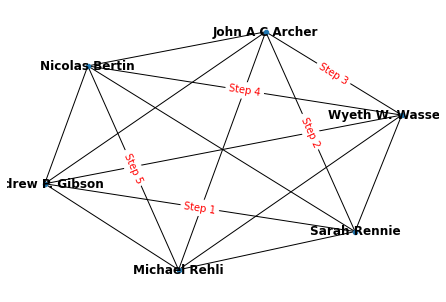

In [378]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_shortest_ordered_route(collaboration_graph, shortest_walk):
    # Estrai il sottografo contenente solo il percorso più breve
    shortest_path_graph = collaboration_graph.subgraph(shortest_walk)

    # Disegna il grafo
    pos = nx.spring_layout(shortest_path_graph)  # Scegli un layout per la visualizzazione
    nx.draw(shortest_path_graph, pos, with_labels=True, font_size=12, font_color='black', font_weight='bold', node_size=20)

    # Identifica gli archi nel percorso più breve
    for i in range(len(shortest_walk) - 1):
        edge_label = f"Step {i+1}"

        nx.draw_networkx_edge_labels(shortest_path_graph, pos, edge_labels={(shortest_walk[i], shortest_walk[i+1]): edge_label}, font_color='red')

    # Mostra il grafico
    plt.show()

# Utilizzo della funzione
print(f"The path starts from {a_1} and ends in {a_n}")
visualize_shortest_ordered_route(collaboration_graph, result)


##  Functionality 5 - Extracting Communities

In [ ]:
import random
import networkx as nx

NOTE: for this exercise was used networkx 

* To initialize the work we create a subgraph of the top N of our citation_graph, to randomly extract the thwo papers needed in the function.
* For the sake of visualization we will set N as 50

In [333]:
N=50
centrality = nx.degree_centrality(citation_graph)
top_N_papers = sorted(centrality, key=centrality.get, reverse=True)[:N]
top_N_graph = citation_graph.subgraph(top_N_papers)
all_nodes = list(G_top_N.nodes())
Paper_1= random.choice(all_nodes)
Paper_2=random.choice(all_nodes)

* We create a function called "girvan_newman_community_detection", inspired by the article linked in the homework
* The funcgtion will output min_edges_removed, final_communities, same_community, that are respectively the minimum number of edges that should be removed to form communities, a list of communities, each containing a list of papers that belong to them, and whether the Paper_1 and Paper_2 belongs to the same community.

In [334]:
def girvan_newman_community_detection(citation_graph ,N, Paper_1, Paper_2):
    
    # we start by selecting a subgraph of the top N papers
    centrality = nx.degree_centrality(citation_graph)
    top_N_papers = sorted(centrality, key=centrality.get, reverse=True)[:N]
    top_N_graph = citation_graph.subgraph(top_N_papers)
    
    # Convert the directed graph to an undirected graph
    G = top_N_graph.to_undirected()

    # Calculate the initial number of connected components (communities)
    initial_communities = list(nx.connected_components(G))
    initial_num_communities = len(initial_communities)

    # Calculate the initial number of edges in the graph
    initial_num_edges = len(G.edges())

    # Iterate until the graph becomes disconnected
    while nx.number_connected_components(G) == initial_num_communities:
        # Calculate betweenness centrality for each edge
        edge_betweenness = nx.edge_betweenness_centrality(G)

        # Find the edge with the highest betweenness centrality
        max_betweenness_edge = max(edge_betweenness, key=edge_betweenness.get)

        # Remove the edge with the highest betweenness centrality
        G.remove_edge(*max_betweenness_edge)

    # Calculate the final number of connected components (communities)
    final_communities = list(nx.connected_components(G))

    # Calculate the final number of edges in the graph
    final_num_edges = len(G.edges())

    # Calculate the minimum number of edges removed to form communities
    min_edges_removed = initial_num_edges - final_num_edges

    # Check whether Paper_1 and Paper_2 belong to the same community in the final graph
    same_community = any(Paper_1 in community and Paper_2 in community for community in final_communities)

    return min_edges_removed, final_communities, same_community

* We run the function and show the results:

In [335]:
min_edges_removed, communities, same_community = girvan_newman_community_detection(citation_graph, int(50), Paper_1, Paper_2)

print(f"Minimum edges removed to form communities: {min_edges_removed}")
print("Communities:")
for i, community in enumerate(communities, 1):
    print(f"Community {i}: {list(community)}")

print(f"Paper_1 and Paper_2 belong to the same community: {same_community}")

Minimum edges removed to form communities: 1
Communities:
Community 1: [2041404167, 2161969291, 2163605009, 2162915993, 2119821739, 2156909104, 2153635508, 2296616510, 2151103935, 2124386111, 2031489346, 2117539524, 2076063813, 2147152072, 2102605133, 2618530766, 2168356304, 1956559956, 2163922914, 2108598243, 2150341604, 1880262756, 2072128103, 2165949425, 2147800946, 2912934387, 1660562555, 1986931325]
Community 2: [1971784203, 47957325, 2121947440, 1501500081, 1639032689, 2159080219]
Community 3: [2100408980, 1987198869, 1791587663]
Community 4: [2125055259]
Community 5: [2156186849, 1996360405, 1655990431]
Community 6: [2118428193]
Community 7: [2096525273, 2141885858]
Community 8: [2164598857, 1988790447]
Community 9: [2066636486]
Community 10: [2130509920]
Community 11: [2148251644, 2157457404]
Paper_1 and Paper_2 belong to the same community: False


## Visualization 5 - Visualize the communities

* Print the number of links that should be removed to have the communities

In [338]:
def print_links_to_remove(citation_graph, Paper_1, Paper_2):
    min_edges_removed, _, _ = girvan_newman_community_detection(citation_graph,N, Paper_1, Paper_2)
    print(f"Number of links to be removed to form communities: {min_edges_removed}")

In [339]:
print_links_to_remove(G_top_N, Paper_1, Paper_2)


Number of links to be removed to form communities: 1


* A table depicting the communities and the papers that belong to each community

In [341]:
def table_communities(citation_graph):
    communities_dict = {}
    for idx, community in enumerate(girvan_newman_community_detection(citation_graph,N, Paper_1, Paper_2)[1], 1):
        communities_dict[f'Community {idx}'] = list(community)

    # Create a DataFrame from the dictionary
    communities_df = pd.DataFrame(list(communities_dict.items()), columns=['Community', 'Papers'])

    return communities_df

# Example usage:
table_df = table_communities(G_top_N)
print(table_df)

       Community                                             Papers
0    Community 1  [2041404167, 2161969291, 2163605009, 216291599...
1    Community 2  [1971784203, 47957325, 2121947440, 1501500081,...
2    Community 3               [2100408980, 1987198869, 1791587663]
3    Community 4                                       [2125055259]
4    Community 5               [2156186849, 1996360405, 1655990431]
5    Community 6                                       [2118428193]
6    Community 7                           [2096525273, 2141885858]
7    Community 8                           [2157457404, 2148251644]
8    Community 9                           [2164598857, 1988790447]
9   Community 10                                       [2066636486]
10  Community 11                                       [2130509920]


* Plot the original graph

In [342]:
def plot_graph(graph, title="Graph"):
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, font_weight='bold')
    plt.title(title)
    plt.show()

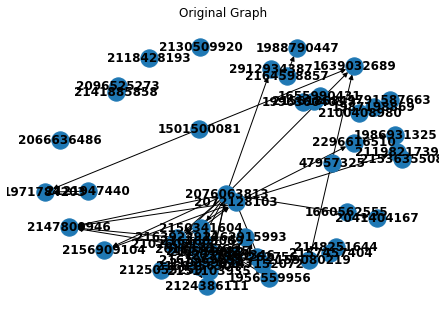

In [343]:
# Plot the original graph
plot_graph(G_top_N, title="Original Graph")

* Plot the graph showing the communities in the network

In [344]:
def plot_communities(graph, communities, title="Graph with Communities"):
    pos = nx.spring_layout(graph)
    colors = range(len(graph.nodes()))
    nx.draw(graph, pos, node_color='#A0CBE2', cmap=plt.cm.Blues, with_labels=True, font_weight='bold')
    nx.draw_networkx_nodes(graph, pos, node_size=700, node_color=colors, cmap=plt.cm.Blues)
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    
    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(graph, pos, nodelist=list(community), node_color=f'C{i}', label=f'Community {i + 1}')

    plt.title(title)
    plt.legend()
    plt.show()


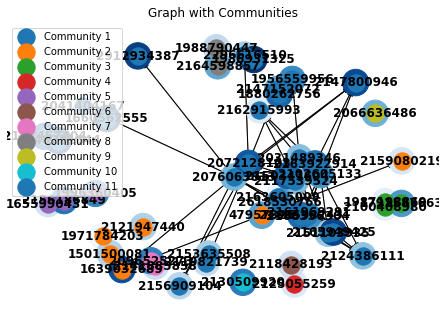

In [345]:
# Plot the graph showing the communities in the network
plot_communities(G_top_N, communities, title="Graph with Communities")

* Plot the final graph and identify the community/communities of Paper_1 and Paper_2

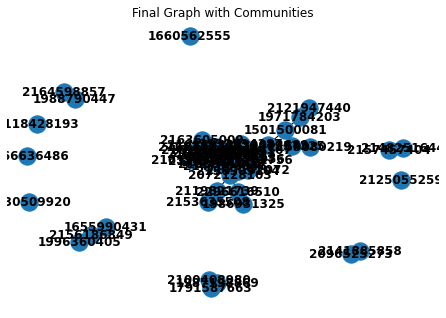

Paper_1 belongs to Community 4
Paper_2 belongs to Community 2


In [346]:
# Plot the final graph and identify the community/communities of Paper_1 and Paper_2
final_graph = gn_detector.graph
plot_graph(final_graph, title="Final Graph with Communities")

# Identify the community/communities of Paper_1 and Paper_2
Paper_1_community = None
Paper_2_community = None

for i, community in enumerate(communities, 1):
    if Paper_1 in community:
        Paper_1_community = i
    if Paper_2 in community:
        Paper_2_community = i

print(f"Paper_1 belongs to Community {Paper_1_community}")
print(f"Paper_2 belongs to Community {Paper_2_community}")